In [1]:
import os
import sys
import time
os.environ['TF_ENABLE_ONEDNN_OPTS'] = str(0)

import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow import keras  # tf.keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import ipyparams
import json

from test_utility import *

print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)
    
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

2023-06-25 09:40:37.384759: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-25 09:40:37.563668: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-25 09:40:38.379841: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-06-25 09:40:38.379991: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic

<IPython.core.display.Javascript object>

python 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) 
[GCC 9.4.0]
matplotlib 3.5.3
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.10.1
keras.api._v2.keras 2.10.0


In [2]:
notebookName = None
try:
    notebookName = os.path.basename(globals()['__vsc_ipynb_file__'])
except:
    pass

if type(notebookName) == str and len(notebookName.split('.')) > 1:  # looks like running on VSCode
    pass
else:  # looks like running on a browser
    notebookName = ipyparams.notebook_name
assert type(notebookName) == str and len(notebookName.split('.')) > 2
notebookName = ".".join(notebookName.split('.')[:-2])   # -2: gets rid of train version and file extention.
print(notebookName)

data_model = notebookName  #"vm03.05.250.11.80.100.16.14.1"
assert len(notebookName.split('.')) >= 8

test--v3.05.300.1.70.eth.16.12


In [3]:
dir_data = "/mnt/data/Trading/"

#===================================================================== Dataset

Nx = 300 # ------------- test
Ny = 1
Ns = 2 #--------------------- test
BatchSize = 1024

Shift = 0 # < 2 history: 0

CandleFile = "18-01-01-00-00-23-05-20-20-23-5m"
CandleFile2 = "23-05-19-00-05-23-06-22-02-40-5m"
SmallSigma = 1
LargeSigma = 30
eFreeNoLog = True

shuffle_batch = 10  # Keep it small to speed up model loading.

dir_candles = os.path.join(dir_data, "Candles")

Volume_Volatility = 3
All_Field_Names = ['ClosePrice', 'BaseVolume', 'BuyerBaseVolume']
min_true_candle_percent_x = 70
chosen_markets_x = []
chosen_fields_names_x = ['ClosePrice'] #, 'BaseVolume']
min_true_candle_percent_y = 70
assert min_true_candle_percent_x == min_true_candle_percent_y
chosen_markets_y = []
chosen_fields_names_y = ['ClosePrice']

target_market_names = None
# target_market_names = ['NEOUSDT', 'LTCUSDT', 'BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'QTUMUSDT', 'ADAUSDT', 'XRPUSDT']
target_market_names = ['ETHUSDT']
tarket_market_top_percent = 15

Standardization = True
Kill_Irregulars = True  # ----------------- pls implement it
Time_into_X = True
Time_into_Y = False #
eFreeNoPlot = True

#======================================================================== Model

Num_Layers = 16 # Wow
Num_Heads = 1   # As we have a single GPU, and we want to a exhaustic attention.
Factor_FF = 4
repComplexity = 12  # Wower
Dropout_Rate = 0.  # You cannot change this once the model is built.

dir_Checkpoint = os.path.join(dir_data, "Checkpoints")
checkpoint_filepath = os.path.join(dir_Checkpoint, data_model)
dir_CSVLogs = os.path.join(dir_data, "CSVLogs")
csvLogger_filepath = os.path.join(dir_CSVLogs, data_model)

#======================================================================== Train

Epochs_Initial = 5000
HuberThreshold = 4.0
Checkpoint_Monitor = "val_loss"
EarlyStopping_Min_Monitor = "val_loss"
EarlyStopping_Patience = 500

Optimizer = "adam"
LR_initial = 1.e-6 # default: 1e-4
LR_rate = 0./100
LR_skip = 0

#=============================================================== Checksum

params = data_model.split('.')
assert int(params[1]) == int(CandleFile.split('-')[-1][:-1])
assert int(params[2]) == Nx
assert int(params[3]) == Ny
assert int(params[4]) == min_true_candle_percent_x
assert int(params[6]) == Num_Layers
assert int(params[7]) == repComplexity
targets = params[5]
if targets.isnumeric():
    assert target_market_names is None
    assert int(targets) == tarket_market_top_percent
else:
    for target in targets.split(','):
        assert (target+'usdt').upper() in target_market_names

#============================================================== Consistency
folders = [dir_data, dir_candles, dir_Checkpoint, dir_CSVLogs]
for folder in folders:
    if not os.path.isdir(folder):
        os.mkdir(folder)

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print(gpus)
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # tf.config.experimental.set_virtual_device_configuration(
            #     gpu,[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)]) # why 5120?
            # logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            # print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

mirrored_strategy = None
if len(gpus) > 1: 
    mirrored_strategy = tf.distribute.MirroredStrategy()
    LR_initial = LR_initial * len(gpus) * 3 / 4

# tf.config.experimental.set_virtual_device_configuration(
#     gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
#==================== Load candle and reports. Data structure depends on TradingBot ====================
Candles = np.load( os.path.join( dir_candles, "table-" + CandleFile + ".npy") )
with open( os.path.join( dir_candles, "reports-" + CandleFile + ".json"), "r") as f:
    reports = json.loads(f.read())

#==================== Load candle and reports. Data structure depends on TradingBot ====================
Candles2 = np.load( os.path.join( dir_candles, "table-" + CandleFile2 + ".npy") )
with open( os.path.join( dir_candles, "reports-" + CandleFile2 + ".json"), "r") as f:
    reports2 = json.loads(f.read())

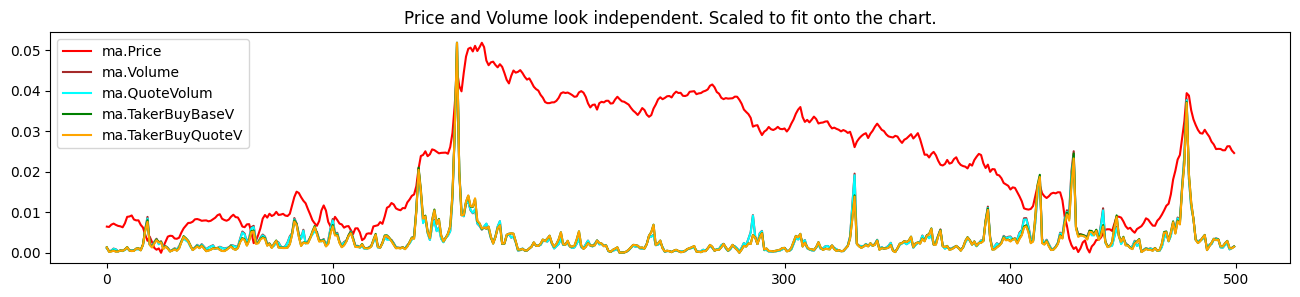

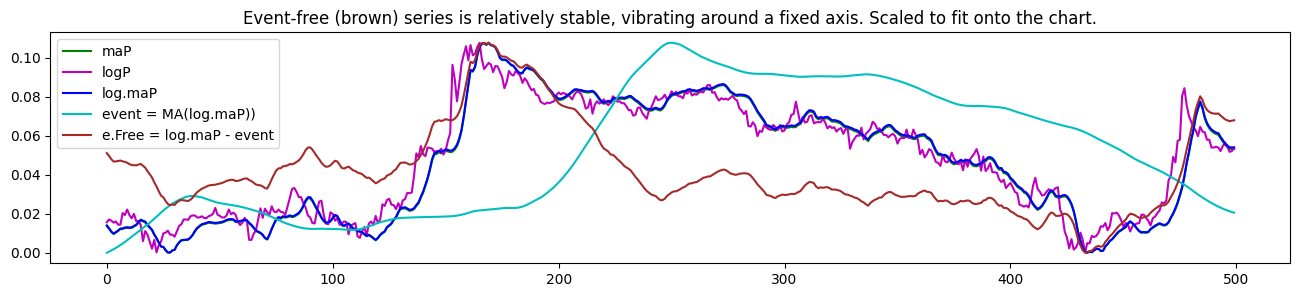

In [6]:
market = 5
Show_Price_Volume_10(Candles[market, :, :], 1, 1, 500)
Event_Free_Learning_Scheme_10(Candles[market, :, :], 3, 30, 500)

In [7]:
#==================== Format candles data ====================================
Candles, CandleMarks, all_market_names, x_indices, y_indices, \
chosen_market_names_x, chosen_field_names_x, chosen_market_names_y, chosen_field_names_y, \
chosen_market_names, chosen_field_names, \
target_markets_names, target_markets = \
get_formed_data_3(
        Candles, reports, All_Field_Names, 
        min_true_candle_percent_x, chosen_fields_names_x, min_true_candle_percent_y, chosen_fields_names_y,
        target_market_names, tarket_market_top_percent
)

In [8]:
print(Candles.shape)
print(CandleMarks.shape)
print(len(all_market_names))
print(x_indices)
print(y_indices)
print(chosen_market_names_x)
print(chosen_field_names_x)
print(chosen_market_names_y)
print(chosen_field_names_y)
print(chosen_market_names)
print(chosen_field_names)
print(target_markets_names)
print(target_markets)
print(len(chosen_market_names_x), len(chosen_market_names_y), len(target_markets_names))

(565633, 45, 1)
(565633, 45)
336
((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44), (0,))
((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44), (0,))
['NEOUSDT', 'LTCUSDT', 'BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'QTUMUSDT', 'ADAUSDT', 'XRPUSDT', 'EOSUSDT', 'XLMUSDT', 'IOTAUSDT', 'ONTUSDT', 'TRXUSDT', 'ETCUSDT', 'ICXUSDT', 'NULSUSDT', 'VETUSDT', 'LINKUSDT', 'WAVESUSDT', 'ONGUSDT', 'HOTUSDT', 'ZILUSDT', 'ZRXUSDT', 'FETUSDT', 'BATUSDT', 'XMRUSDT', 'ZECUSDT', 'IOSTUSDT', 'CELRUSDT', 'DASHUSDT', 'OMGUSDT', 'THETAUSDT', 'ENJUSDT', 'MATICUSDT', 'ATOMUSDT', 'TFUELUSDT', 'ONEUSDT', 'FTMUSDT', 'ALGOUSDT', 'DOGEUSDT', 'DUSKUSDT', 'ANKRUSDT', 'WINUSDT', 'COSUSDT', 'COCOSUSDT']
['ClosePrice']
['NEOUSDT', 'LTCUSDT', 'BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'QTUMUSDT', 'ADAUSDT

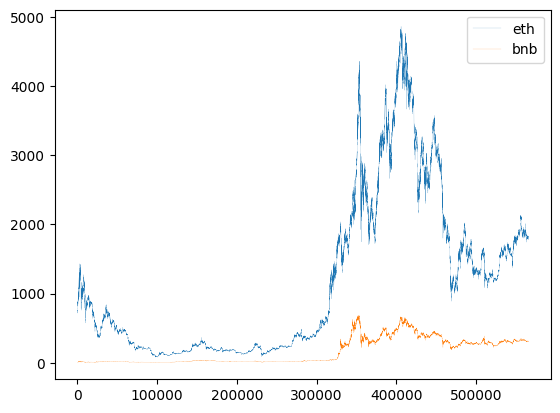

In [9]:
market = all_market_names.index("ETHUSDT")
plt.plot(Candles[:, market, 0], label='eth', linewidth=0.1)
market = all_market_names.index("BNBUSDT")
plt.plot(Candles[:, market, 0], label='bnb', linewidth=0.1)
plt.legend()
plt.show()

In [10]:
Candles2, CandleMarks2, missing_names2 = get_conformed_data_3(
    Candles2, reports2, chosen_market_names,
    All_Field_Names, chosen_field_names
 )

missing_markets ['COCOSUSDT']


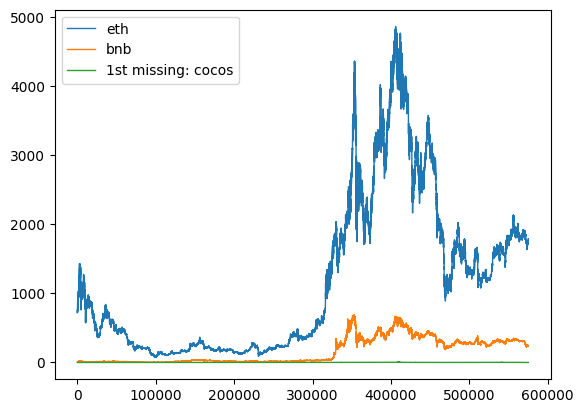

In [11]:
market = all_market_names.index("ETHUSDT")
joined = np.concatenate([Candles[:, market, 0], Candles2[:, market, 0]], axis=0)
plt.plot(joined, label='eth', linewidth=1)
market = all_market_names.index("BNBUSDT")
joined = np.concatenate([Candles[:, market, 0], Candles2[:, market, 0]], axis=0)
plt.plot(joined, label='bnb', linewidth=1)
if len(missing_names2) > 0:
    market = all_market_names.index(missing_names2[0])
    joined = np.concatenate([Candles[:, market, 0], Candles2[:, market, 0]], axis=0)
    plt.plot(joined, label="1st missing: " + missing_names2[0][:-len('USDT')].lower(), linewidth=1)
plt.legend()
plt.show()

In [12]:
#=========================== Get time features ======================
start_ts, interval_s, timestamps_abs, Times = get_time_features_2(CandleFile, Candles.shape[0], Candles.dtype)
size_time = Times.shape[1]

start_ts2, _, timestamps_abs2, Times2 = get_time_features_2(CandleFile2, Candles2.shape[0], Candles2.dtype)
assert timestamps_abs2[0] - timestamps_abs[-1] == interval_s

In [13]:
print(Candles.shape, Times.shape)
print(timestamps_abs[:5])
print(Candles2.shape, Times2.shape)
print(timestamps_abs2[:5])
# print(Times[:5])    # Agnostic of restart of this training notebook.

(565633, 45, 1) (565633, 4)
[1514764800 1514765100 1514765400 1514765700 1514766000]
(9504, 45, 1) (9504, 4)
[1684454700 1684455000 1684455300 1684455600 1684455900]


In [14]:
#========================= Get sample anchors ==============================
sample_anchors_t, sample_anchors_v = get_sample_anchors_3(Candles, Nx, Ny, Ns, seed=523)
print(sample_anchors_t.shape, sample_anchors_v.shape)
print(sample_anchors_t[:5])
assert sample_anchors_t[0] == 206568  
assert sample_anchors_t[1] == 407538 

sample_anchors_t2, sample_anchors_v2 = get_sample_anchors_3(Candles2, Nx, Ny, Ns, seed=523)
print(sample_anchors_t2.shape, sample_anchors_v2.shape)
print(sample_anchors_t2[:5])
assert sample_anchors_t2[0] == 8802  
assert sample_anchors_t2[1] == 974 

(197866,) (84800,)
[206568 407538 169838 376398 421090]
(3220,) (1381,)
[8802  974 6038 6824 3944]


In [15]:
JointCandles, JointMarks, sample_anchors_t, sample_anchors_v = \
    get_joint_data(
        Candles, CandleMarks, sample_anchors_t, sample_anchors_v,
        Candles2, CandleMarks2, sample_anchors_t2, sample_anchors_v2
    )

(575137, 45, 1)
565330
[574132 566304 571368 572154 569274]
(201086,) (86181,)


In [16]:
print(JointCandles.shape)
print(sample_anchors_t.shape, sample_anchors_v.shape)

(575137, 45, 1)
(201086,) (86181,)


In [17]:
start_ts, interval_s, timestamps_abs, JointTimes = get_time_features_2(CandleFile, JointCandles.shape[0], JointCandles.dtype)
size_time = Times.shape[1]

In [18]:
#======================== Get event-free data ========================

org_length = JointCandles.shape[0]
JointCandles, JointMarks, JointTimes = get_eventfree_data(
    JointCandles, JointMarks, JointTimes,
    SmallSigma, LargeSigma, all_market_names, chosen_market_names, 
    All_Field_Names, chosen_field_names,
    eFreeNoLog, eFreeNoPlot, Volume_Volatility
)

In [19]:
assert JointCandles.shape[0] == JointMarks.shape[0]
assert JointCandles.shape[0] == JointTimes.shape[0]
print(JointCandles.shape, CandleMarks.shape, JointTimes.shape, org_length-JointCandles.shape[0])
# print(Candles[-3:]) # Agnostic of restart of this training notebook.

(575046, 45, 1) (565633, 45) (575046, 4) 91


In [20]:
#========================= Standardize data ============================
Standard = None
if Standardization:
    JointCandles, Standard = standardize_2(JointCandles)
# print(Candles[-3:]) # Agnostic of restart of this training notebook.

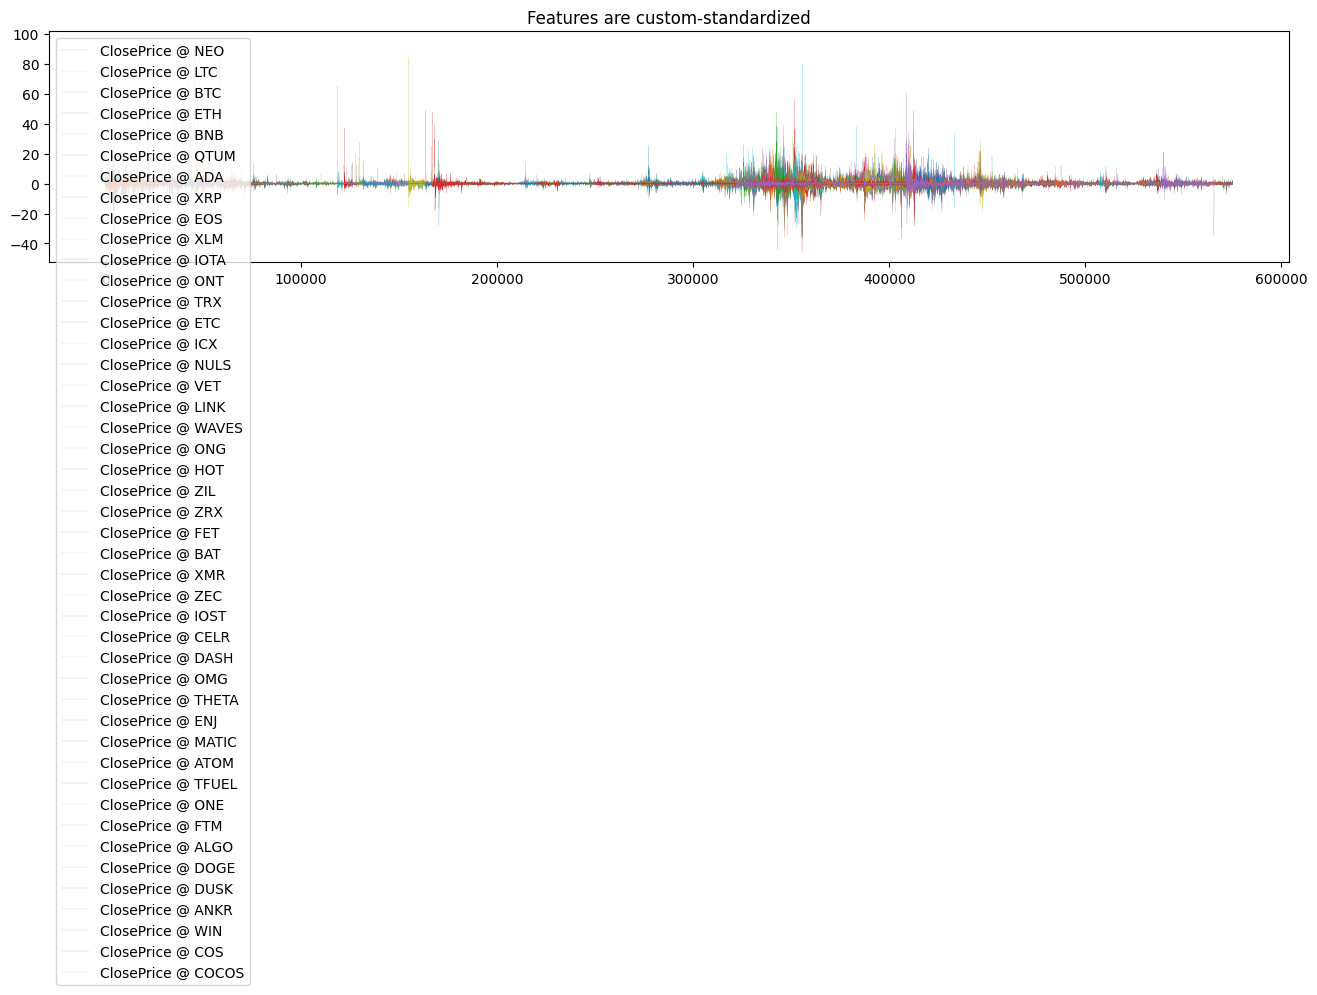

In [21]:
fig = plt.figure(figsize=(16,3))
ax = fig.add_subplot(111)
ax.set_title("Features are custom-standardized" if Standardization else "Features are not standardized")
for market in range(JointCandles.shape[1]):
    for field in range(JointCandles.shape[2]):
        ax.plot(JointCandles[:, market, field], label = "{} @ {}".format(All_Field_Names[field], all_market_names[market][:-len('USDT')]), lw=0.1)
ax.legend(loc = 'upper left')
plt.show()

In [22]:
ds_train, ds_valid, dx, dy = \
get_datasets_3(
    JointCandles, Time_into_X, Time_into_Y, JointTimes, 
    sample_anchors_t, sample_anchors_v,
    Nx, x_indices, Ny, y_indices, size_time, target_markets, Shift,
    BatchSize, shuffle_batch, shuffle=(len(gpus)<=1)
)

2023-06-25 09:42:15.362432: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-25 09:42:16.022213: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38239 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


In [23]:
model = None

if mirrored_strategy is None:
    model = build_model_3(
        dx, dy, Num_Layers, Num_Heads, Factor_FF, repComplexity, Dropout_Rate,
        HuberThreshold, Optimizer, initial=LR_initial, rate=LR_rate, skip=LR_skip
    )
else:
    with mirrored_strategy.scope():
        model = build_model_3(
            dx, dy, Num_Layers, Num_Heads, Factor_FF, repComplexity, Dropout_Rate,
            HuberThreshold, Optimizer, initial=LR_initial, rate=LR_rate, skip=LR_skip
        )

In [24]:
callbacks = get_callbacks(
    checkpoint_filepath, Checkpoint_Monitor, 
    csvLogger_filepath, 
    EarlyStopping_Min_Monitor, EarlyStopping_Patience
)
try:
    model.load_weights(checkpoint_filepath)
    print("Loading a checkpoint...done")
except:
    print("No chekkpoint to load. Fitting initailly...")
    model.fit(
        ds_train, # x and y_true
        validation_data=ds_valid,
        epochs=1, #Epochs_Initial,
        callbacks=callbacks
    )
try:
    columns = ('loss', 'val_loss', 'mTA', 'val_mTA')
    plot_csv_train_history(csvLogger_filepath, columns, title=data_model)
except:
    pass

No chekkpoint to load. Fitting initailly...


2023-06-25 09:43:28.860112: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-25 09:43:29.569054: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


 81/197 [===========>..................] - ETA: 1:41 - loss: 0.3812 - mTA: 0.0000e+00

In [ ]:
model.summary()

In [ ]:
model.fit(
    ds_train, # x and y_true
    validation_data=ds_valid,
    epochs=Epochs_Initial,
    callbacks=callbacks
)

In [ ]:
columns = ('loss', 'val_loss', 'mTA', 'val_mTA')
plot_csv_train_history(csvLogger_filepath, columns, title=data_model)